# Spectral Clustering

### Project members:
Mengshu Shao, Yelena Kernogitski

### GitHub Repositories: 
https://github.com/yelenakernogitski/Spectral-Clustering-Project

## Abstract
Clustering is one of the building blocks in modern data analysis, and has been widely used in machine learning and pattern recognition. Two commonly used approaches are K-means and learning a mixture model using EM. However, these methods have some drawbacks, such as violation of the harsh simplifying assumption which the density of each cluster is Gaussian. One method that provides a possible solution in finding useful clusters is spectral clustering, which utilizes eigenvectors derived from the distance between points. The method performs dimensionality reduction in order to find clusters. In this report, First we implement a simple spectral clustering algorithm for clustering points in . Second we analyze how it works in “ideal” case in which the points are far apart, and in general case in which affinity’s off-diagonal blocks are non-zero. Then we test the algorithm by applying it to a number of challenging clustering problems. Further, we attempt to optimize the algorithm using within-Python options (such as vectorization) in addition to JIT and Cython wrapping functions. We also attempt to optimize our method by using multiprocessing parallel computing. Finally, we compare our algorithm which includes spectral clustering and subsequent Kmeans to using only spectral or Kmeans clustering. 

## 1. Introduction

A significant aim of machine learning and pattern recognition is finding appropriate clusters that are able to accurately classify data points. Two standard approaches used in clustering are K-means and Expectation-Maximazation which allow for learning a mixture model. The latter has severe drawbacks where we must estimate the density of each cluster to be Gaussian due to parametric assumptions, and the log likelihood may result in getting caught in a local minima, and many various initial values may need to be used [1]. K-means clustering by itself leads to other problems, such as not being able to accomodate non-spherical data, and other complex datasets. A method that provides a possible solution in finding useful clusters in spectral clustering, which utilizes eigenvectors derived from the distance between points. An additional part of our algorithm uses the eigenvectors found in K-means clustering, as opposed to using the original dataset found. It has been found in empirical studies that the latter method is more accurate in classifying clusters [1]. In this report, we first implement our spectral clustering algorithm for clustering point in $\mathbb{R}^n$ in simple python code. Second, we check whether the algorithm works using an "ideal" case in which the points are far apart. We then attempt to optimize our algorithm by using various methods--such as vectorization, JIT, and cython wrapping funcions. Next, we try to optimize our algorithm using multiprocessing parallel computing. Finally, we apply the algorithm to a number of challenging clustering problems and compare our algorithm to using only kmeans or spectral clustering.

### 1.1 Background of Method

Spectral clustering has become a popular way of clustering data, especially when trying to do exploratory data analysis in a number of fields. Spectral clustering relies on using eigendecomposition to find optimal clusters. Spectral clustering has been empirically shown to outperform methods like simply k-means or single linkage [2]. An important part of spectral clustering are Laplacian matrices, which is then used in the eigendecomposition. The original data is transformed into its affinity matrix, or a similarity matrix which is a symmetric matrix which measures the similarity between data points by index. This which is then used to construct the Laplacian matrix. Laplacian matrices are generally matrix representation of a graph and have been described previously [3]. Spectral clustering has been modified to optimize in specific ways, where at times the Laplacian matrix is either normalized in a particular way, or not normalized and the treatment of the eigenvectors is further open to variation [2]. Our method in particular uses the symmetric normalized Laplacian matrix. 

## 2. Spectral Clustering Algorithm

Our algorithm has been previously described in (Ng et al, 2002). Provided a set of points $S= {s_1,...,s_n}$ in $\mathbb{R}^l$ that we want to clsuter into $k$ subsets:

$1.$ Define the affinity matrix $A \in \mathbb{R}^{nxn}$ by $A_{ij}=exp(-||s_i-s_j||^2 / 2\sigma^2)$ if $i\neq{j}$, and $A_{ii}=0$.
    
    
$2.$ Create a diagonal matrix whose ($i$,$i$) element is the sum of $A's$ i-th row, and construct L, where $L= D^{-1/2}AD^{-1/2}$.
    
    
$3.$ Find ${x_1,...,x_n}$, the $k$ largest eigenvectors of $L$, which are chosen to be orthogonal to one another in the chance there are repeated eigenvalues. Then create the matrix $X$, by placing the k eigenvectors in columns.
    
    
$4.$ Use $X$ to form the matrix $Y$, by normalizing each X's rows to have unit length (i.e. $Y_{ij}=X_{ij}/(\sum_{j}{}X_{ij}^2)^{1/2}$). 
    
    
$5.$ Treating each row of $Y$ as a point in $\mathbb{R}^k$, cluster into $k$ clusters using K-means
    
    
$6.$ Assign the original point $s_i$ to cluster $j$ if row $i$ of the matrix $Y$ was assigned to cluster $j$. 

Our scaling parameter $\sigma^2$ was found by minimizing the distortion of the Y matrix and the clustering centers that correspond to each assigned cluster. The distortion was found by summing over the Euclidean distances between each data point and the center of its assigned cluster. We found $\sigma^2$ by using an iterative procedure to find which value of $\sigma^2$ minimized the distortion. Generally, $\sigma^2$ can be determined using human input, but this process automizes the procedure. 

In this report we followed the algorithm described in (Ng et al, 2002) closely. We assumed that the eigenvectors are chosen to be orthogonal to one another based on the eigenvector-calculating method in scipy. This was not further analyzed. Further, the assumptions and proofs can be referenced in the paper, but the derivation is outside the scope of this report. 

Additiaonally, this paper suggested to automate the ideal variance to use in our algorithm (Step 1 above, in finding affinity matrix). The authors found a variance by searching over various  variances to find one that minimizes the distortion, or gives the tightest clusters [1]. This method of finding the variance was not used as a formal algorithm in the paper, but in our report we use our optimal-variance-finder function in one of our optimization methods. 

### 2.1 Algorithm

In [1]:
import numpy as np
import scipy.linalg as la
from numpy.core.umath_tests import inner1d
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from more_itertools import unique_everseen
import numba
from numba import *
import time
import timeit
from numpy.testing import assert_almost_equal
import sklearn.cluster as sc
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.cm as cm
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool, Value, Array
import multiprocessing
from timeit import default_timer as timer
import random

For detailed algorithm and illustration of the algorithm, please refer to the "Illustration_of_Algorithm.ipynb". Here we'll mainly list the functions we used in our application. For Cython and Mltiprocessing part, we created some new sub-functions to make the program easier without change to the results.

#### Algorithm Step 1: Form the affinity matrix

$\textbf{affinity}(s, var)$
* Form the affinity matrix
* Parameters
    * s: array-like, shape (n_samples, n_features)
        * Training vectors, where n_samples is the number of samples and n_features is the number of features.
    * var: float, $\sigma^2$
        * scaling parameter controlling how rapidly the affinity $A_{ij}$ falls off with the distance between $s_i$ and $s_j$.
* Returns
    * A: array-like, shape (n_samples, n_samples)
        * Affinity matrix.
      

In [2]:
def affinity(s, var):
    n = np.shape(s)[0]
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, i] = 0
            A[i,j] = np.exp(-(la.norm(s[i] - s[j])**2) / (2*var))
    return A

#### Algorithm Step 2: Create the D and L matrix

$\textbf{findD}(s)$
* Form the affinity matrix
* Parameters
    * s: array-like, shape (n_samples, n_features)
        * Training vectors, where n_samples is the number of samples and n_features is the number of features.
* Returns
    * D: array-like, shape (n_samples, n_samples)
        * A diagonal matrix whose ($i$,$i$) element is the sum of $A's$ i-th row.

In [3]:
def findD(s):
    n = np.shape(s)[0]
    A = affinity(s, var=bestvariance)
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = 1/(A[i].sum())
    return D

In [4]:
#L = np.sqrt(D).dot(A).dot(np.sqrt(D))               These commented parts are embedded in the final function

#### Algorithm Step 3: Find k largest eigenvectors and place in X matrix

In [5]:
#value, vector = la.eig(L)
#idx = np.argsort(value)[::-1]
#value = value[idx]
#vector = vector[:, idx]
#X = vector[:, 0:k]

#### Algorithm Step 4: Find Y matrix by normalizing X

In [6]:
#Y = X / np.sum(X, 1)[:, np.newaxis]

#### Algorithm Step 5: K-means clustering

$\textbf{kmeans_our}(y, k, max_iter=10)$
* K-Means Clustering
* Parameters
    * y: array-like, shape (n_samples, k)
        * Training vectors, where n_samples is the number of samples and k is the number of clusters.
    * k: int
        * The number of clusters to form as well as the number of centroids to generate.
    * max_iter: int
        * The number of iterations taken to get the final clustering.
* Returns
    * clusters: array-like, shape (n_samples, 1)
        * The clusters of which the data point belongs to.
    * idx_data: array-like, shape (k, n_features)
        * The centroids generated from K-Means clustering.

In [7]:
def kmeans_our(y, k, max_iter=10):
    idx = np.random.choice(len(y), k, replace=False)
    idx_data = y[idx]
    for i in range(max_iter):
        dist = np.array([inner1d(y-c, y-c) for c in idx_data])
        clusters = np.argmin(dist, axis=0)
        idx_data = np.array([y[clusters==i].mean(axis=0) for i in range(k)])
    return (clusters, idx_data)

#### Algorithm Step 1-6: Final clustering on the original data set

$\textbf{finalclustering}(s,var,k)$
* Final clustering on the datapoints
* Parameters
    * s: array-like, shape (n_samples, n_features)
        * Training vectors, where n_samples is the number of samples and n_features is the number of features.
    * var: float
        * The best variances.
    * k: int
        * The number of clusters.
* Returns
    * final: array-like, shape (n_samples, n_features+1)
        * The original set of datapoints with the clusters. 
    * data: array-like, shape (k, n_features)
        * The centroids of K-means clustering.
    * clusters: array-like, shape (n_samples)
        * The clusters.

In [8]:
def finalclustering(s,k,var,seed=4):
    np.random.seed(seed)
    n = np.shape(s)[0]
    A=affinity(s,var)
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = 1 / (A[i].sum())

    L = np.sqrt(D).dot(A).dot(np.sqrt(D))

    value, vector = la.eig(L)

    idx = np.argsort(value)[::-1]
    value = value[idx]
    vector = vector[:, idx]

    X = vector[:, 0:k]
    Y = X / np.sum(X, 1)[:, np.newaxis]

    clusters,data=kmeans_our(Y, k, max_iter=10)
    final=np.concatenate((s, clusters.reshape((len(clusters),1))), axis = 1)
    return(final,data,clusters)

### 2.2 Find Optimal Variance

#### Find the best $\sigma^2$

#### Distortion

* Suppose for a point $x$, you replace its coordinates by the cluster center $c_{x}$ it belongs to (lossy compression).
* Measure it with squared Euclidean distance: $x(d)$ is the $d-th$ feature dimension, $y(x)$ is the cluster ID that $x$ is in.
    * $\sum_{d=1...D}{}[x(d)-c_{y(x)}(d)]^2$
* This is the distortion of a single point x. For the whole dataset, the distortion is:
    * $\sum_{x}{}\sum_{d=1...D}{}[x(d)-c_{y(x)}(d)]^2$

$\textbf{dist}(x,y)$
* Calculate the distance between two matrices
* Parameters
    * x: array-like 
        * One of the vectors.
    * y: array-like
        * One of the vectors.
* Returns
    * res: float
        * Squared Euclidean distance.

In [9]:
def dist(x,y):  
    res = np.sum((x-y)**2)
    return res

$\textbf{findbestvar}(s,vari,k)$
* Find the best variance by minimizing the distortion
* Parameters
    * s: array-like, shape (n_samples, n_features)
        * Training vectors, where n_samples is the number of samples and n_features is the number of features.
    * vari: array-like, shape (n_vars)
        * An array of possible variances.
    * k: int
        * The number of clusters
* Returns
    * vari[bestvar]: float
        * The right $\sigma^2$ with mizimum distortion.

In [10]:
def findbestvar(s,vari,k,seed=5): 
    np.random.seed(seed)
    n = np.shape(s)[0]
    dis=[]
    for j in range(len(vari)):
        var=vari[j]
        A=affinity(s,var)
        D = np.zeros((n, n))
        for i in range(n):
            D[i, i] = 1 / (A[i].sum())

        L = np.sqrt(D).dot(A).dot(np.sqrt(D))

        value, vector = la.eig(L)

        idx = np.argsort(value)[::-1]
        value = value[idx]
        vector = vector[:, idx]

        X = vector[:, 0:k]
        Y = X / np.sum(X, 1)[:, np.newaxis]

        clusters,data=kmeans_our(Y, k, max_iter=100)

        snew=pd.DataFrame(s)
        snew['cluster'] = clusters
        b=pd.DataFrame(data)
        cluster=list(unique_everseen(clusters))
        b['cluster']=cluster
        x=pd.merge(snew, b, on='cluster', how='outer')
        c=x.ix[:,0:snew.shape[1]-1] 
        c=np.array(c)
        d=x.ix[:,snew.shape[1]:x.shape[1]]
        d=np.array(d)
        distance=dist(c,d)

        dis.append(distance)
    
    bestvar=np.argmin(dis)
    return(vari[bestvar])


### 2.2 Test algorithm on "ideal" datasets

In the previous part, we list all the functions to get to the final clustering of the data points. To better understand the application of the algorithm, we can consider its performance on the "ideal" dataset in which all points in different clusters are far apart from each other. Here we generated isotropic Gaussian blobs of sample size 100 with two centers [5,5] and [20,20] for clustering. The data points are obviously belong to two different clusters. 

Then to find the best variance for this case, use $finalclustering(s,k,var=bestvariance)$ to cluster the data points into 2 clusters. We set the possible variances to be evenly spaced numbers from 0.01 to 10 and chose the best variance by minimizing the distortion.

The clustered points are shown in the figure below. According to the figure, under the "ideal" case where the data points in different clusters are far apart, our algorithm behaves well on clustering. 

We also recorded the time in order to compare it with JIT and Cython.

In [11]:
batch_size = 100
centers = [[5, 5], [20, 20]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=100, centers=centers, cluster_std=0.7,random_state=5)

s=X

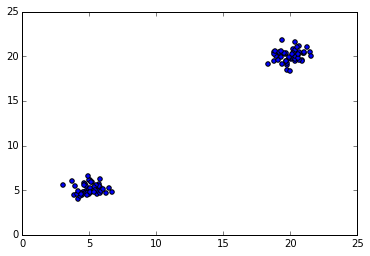

In [12]:
fig, ax = plt.subplots()
ax.scatter(s[:,0],s[:,1])
pass

In [13]:
vari= np.linspace(0.01, 20, 100)
k = 2
bestvariance=findbestvar(s,vari,k,seed=2)

In [14]:
bestvariance

3.8464646464646464

In [15]:
final,centers,clusters=finalclustering(s,k,var=bestvariance,seed=6)

Clustering plot using pure python 0.958300 s


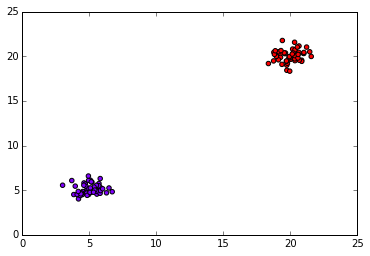

In [16]:
start = time.clock()
final,centers,clusters=finalclustering(s,k,var=bestvariance,seed=7)
time_1 = time.clock() - start

fig, ax = plt.subplots()
ax.scatter(final[:,0],final[:,1],c=final[:,2],cmap=cm.rainbow)

print("Clustering plot using pure python %f s" % time_1)

pass

In [17]:
%%time 
finalclustering(s,k,var=findbestvar(s,vari,k,seed=9))
pass

CPU times: user 28.5 s, sys: 1min 15s, total: 1min 43s
Wall time: 20.5 s


## 3. Function optimization

### 3.1 Using JIT

In this part we're attempting to optimize the algorithm by using Just-In-Time (JIT) compiler. The advantage of JIT is that it can spped up the application written directly in Python without having to switch languages or Python interpreters.

We here tried to use JIT to optimize $affinity(s, var)$, $findbestvar(s,vari,k)$ and $finalclustering(s,k,var)$. The running time is recorded and using $report$ function to generate the speed-up ratio relatively to the original fucntions in pure python.

In [18]:
@jit()
def affinity(s, var):
    n = np.shape(s)[0]
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            A[i, i] = 0
            A[i,j] = np.exp(-(la.norm(s[i] - s[j])**2) / (2*var))
    return A

@jit()
def findbestvar_jit(s,vari,k): 
    n = np.shape(s)[0]
    dis=np.empty((1))
    for j in range(len(vari)):
        var=vari[j]
        A=affinity(s,var)
        D = np.zeros((n, n))
        for i in range(n):
            D[i, i] = 1 / (A[i].sum())

        L = np.sqrt(D).dot(A).dot(np.sqrt(D))

        value, vector = la.eig(L)

        idx = np.argsort(value)[::-1]
        value = value[idx]
        vector = vector[:, idx]

        X = vector[:, 0:k]
        Y = X / np.sum(X, 1)[:, np.newaxis]

        clusters,data=kmeans_our(Y, k, max_iter=100)

        snew=pd.DataFrame(s)
        snew['cluster'] = clusters
        b=pd.DataFrame(data)
        cluster=list(unique_everseen(clusters))
        b['cluster']=cluster
        x=pd.merge(snew, b, on='cluster', how='outer')
        c=x.ix[:,0:snew.shape[1]-1] 
        c=np.array(c)
        d=x.ix[:,snew.shape[1]:x.shape[1]]
        d=np.array(d)
        distance=dist(c,d)

        dis = np.vstack((dis, distance))
    
    bestvar=np.argmin(dis)
    return(vari[bestvar])

In [19]:
@jit()
def finalclustering_jit(s,k,var):
    n = np.shape(s)[0]
    A=affinity(s,var)
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = 1 / (A[i].sum())

    L = np.sqrt(D).dot(A).dot(np.sqrt(D))

    value, vector = la.eig(L)

    idx = np.argsort(value)[::-1]
    value = value[idx]
    vector = vector[:, idx]

    X = vector[:, 0:k]
    Y = X / np.sum(X, 1)[:, np.newaxis]

    clusters,data=kmeans_our(Y, k, max_iter=10)
    final=np.concatenate((s, clusters.reshape((len(clusters),1))), axis = 1)
    return(final,data,clusters)

Clustering plot using pure python 1.195447 s


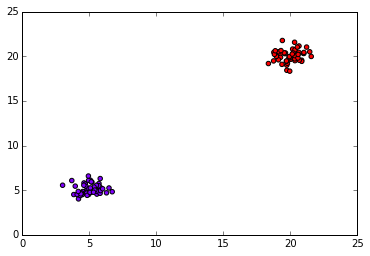

In [20]:
import matplotlib.cm as cm

start = time.clock()
final2=finalclustering_jit(s=s, k=2, var=bestvariance)[0]
time_2 = time.clock() - start

fig, ax = plt.subplots()
ax.scatter(final2[:,0],final2[:,1],c=final2[:,2],cmap=cm.rainbow)

print("Clustering plot using pure python %f s" % time_2)

pass

In [21]:
%%time 
finalclustering_jit(s,k,var=findbestvar_jit(s,vari,k))
pass

CPU times: user 29.4 s, sys: 1min 11s, total: 1min 40s
Wall time: 22 s


### Compare the ratio of speed-up using JIT

According to the report, functions using JIT didn't speed up the application and sometimes even slower. It might be possibly because our functions are written based on heavey numpy and scipy packages and JIT can't do much speeding up in this case.

In [22]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start

In [23]:
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

In [24]:
report([finalclustering, finalclustering_jit], s,k,findbestvar(s,vari,k))

finalclustering: 1.0
finalclustering_jit: 0.9


### 3.2 Using Cython

In this part, we tried Cython to optimize our applications. Cython makes writing C extensions for Python as easy as Python itself. Here we only attempted to optimize the $finalClustering$ function but not the $findBestVariance$ part. Note in the $finalClustering$ function we called Kmeans function, and for simplicity, we called sklearn.cluster.KMeans instead of the Kmeans function we wrote ourselves. In addition, we added one more attribute in the Cython function "D" which can be found by the function $findD$ to avoid some errors when compiling Cython. So the number of attributes in the Cython function is different from what we have in the original function, but it does not affect the results.

We noticed there's still a relatively large part of our code is at Python interaction, so the optimization might not be perfect.

Similarly, the running time is recorded for original functions and Cython.

In [25]:
%load_ext Cython

In [26]:
%%cython 

import cython
from cython.parallel import parallel, prange
from sklearn.cluster import KMeans
import numpy as np
import scipy.linalg as la
import pandas as pd
from numpy.core.umath_tests import inner1d
from more_itertools import unique_everseen
@cython.boundscheck(False)
@cython.wraparound(False)

cdef double[:,:] affinity_cython(double[:,:] s, double var):
    cdef int i, j, k, n, m
    cdef double s_sum
    cdef double[:,:] A
    n, m = np.shape(s)
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 0
        for j in range(n):
            s_sum = 0
            for k in range(m):
                s_sum += (s[i,k] - s[j,k])**2
                A[i,j] = np.exp(-s_sum) / (2*var)
    return A
    
def finalclustering_cython(double[:,:] s, int k, double var, double[:,:] D):
    cdef int i, n
    cdef long[:] idx
    cdef int[:] clusters
    cdef int[:,:] clusters_reshaped
    cdef double[:,:] A, L, vector, vector_sorted, X, Y, data, final
    cdef double[:] value, sum_A
    
    n = np.shape(s)[0]
    A=affinity_cython(s,var)
        
    L = np.sqrt(D).dot(A).dot(np.sqrt(D))
    value = la.eig(L)[0].real
    vector = la.eig(L)[1].real
    
    idx = np.argsort(value)[::-1]
    vector_sorted = np.empty((n, n))
    for i in range(n):
        vector_sorted[i] = vector[idx[i]]
        
    X = vector[:, 0:k]
    Y = X / np.sum(X, 1)[:, np.newaxis]
    clusters = KMeans(k).fit_predict(Y)
    clusters_reshaped = np.empty((n, 1), dtype=np.int32)
    for i in range(n):
        clusters_reshaped[i][0] = clusters[i]
    final = np.concatenate((s, clusters_reshaped), axis = 1)
    return final

Clustering plot using pure python 0.366975 s


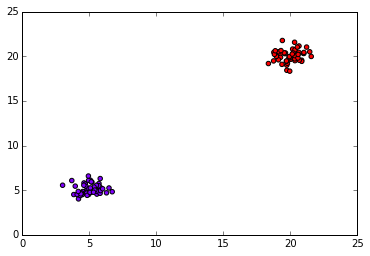

In [27]:
start = time.clock()
d = findD(s)
final3=finalclustering_cython(s=s, k=2, var=bestvariance, D = d)
time_3 = time.clock() - start

fig, ax = plt.subplots()
ax.scatter(final3[:,0],final3[:,1],c=final3[:,2],cmap=cm.rainbow)

print("Clustering plot using pure python %f s" % time_3)

pass

### Compare the ratio of speed-up using Cython

Comparing the times of pure Python and Cython, Cython did not do much on speeding up, the speed up ratio is approximately between 1 and 2. And for illustration, we just used sample size of 100 so we do not see much speed-up here. If comparing the time for the plotting part, the time used for the original function is approximately 0.96s, for numba is 1.48s, and for Cython is 0.35s, so Cython speeds up a little than the original function and numba. 

In [28]:
start = time.clock()
finalclustering(s,k,bestvariance)
ori=time.clock()-start

In [29]:
start = time.clock()
finalclustering_cython(s,k,bestvariance,d)
cyt=time.clock()-start

In [30]:
print("Ratio of speed up using Cython:", ori/cyt)

Ratio of speed up using Cython: 1.3470604494608183


## 4. High Performance Computing 

As the previous attempts to optimize our code did not improve the computation time, we tried to optimize the code using multiprocessing programming for parallel execution. Given that we find clusters based on the entire dataset, using multiprocessing programming may not be ideal, as information is lost. However, if the dataset is large, the trade-off of some loss of information for faster computing time may be worthwhile. 

### 4.1 Multiprocessing for Variance Optimizer

Our function to find optimal variance for our algorithm is a limiting part of our algorithm pipeline. This is because the algorithm can be run many times (user-defined) to find the optimal variance based on minimum distortion. Dealing with a large dataset makes finding an optimal variance very cumbersome computationally. We attempt to parallelize our function to find the best variance in two different ways: In one, we split our dataset, in the other we split our list of variances to test for least distortion. We created a dataset with 100 observations and tested whether either method would improve computational efficiency. We also checked whether the variance chosen was distinct from the variance chosen when using our original function. We expected the former method, where we split up the dataset, to lose some information, and therefore result in a variance that may not be consistent with the variance found without parallel programming. This issue should decrease with a larger dataset. 

In order to be able to parallelize the variances checked, we had to partition our functions to smaller ones. The function 
$matrixY$ does the first part of our full optimal variance-finder algorithm, where we come up with a matrix $Y$ that is then used in Kmeans.

$\textbf{matrixY}(s,var,k=2,seed=55)$
* Find Y matrix--normalize eigenvectors of the transformed original data matrix
* Parameters
    * s: array-like, shape (n_samples, n_features)
        * Dataset, where n_samples is the number of samples and n_features is the number of features in data. 
    * var: int
        * The variance to be used in calculation of affinity matrix
    * k: int
        * The number of eigenvectors to use in kmeans clustering. 
    * seed: int
        * Specify seed for reproducibility.
* Returns
    * Y: array-like, shape (n_samples, k)
        * The Y matrix of our original data, length of k.

The next part of our optimal variance-finder algorithm requires finding the distortion using the output from function
$matrixY$. The following function $findDistortion$ results in a distortion value that can subsequently be used for optimization purposes.  

$\textbf{findDistortion}(Y,s,k=2,seed=6)$
* Find distortion using Y matrix and original dataset s. 
* Parameters
    * Y: array-like, shape (n_samples, k)
       * Y matrix achieved from using Ymatrix function, where n_samples is the number of samples and k is the number of eigenvectors used.
    * s: array-like, shape (n_samples, n_features)
        * Dataset, where n_samples is the number of samples and n_features is the number of features in data. 
    * k: int
        * The number of eigenvectors to use in kmeans clustering. 
    * seed: int
        * Specify seed for reproducibility.
* Returns
    * distance: int
        * The distortion found by calculating the distance of the data 2 with the clusters assigned.

The final part of our optimal variance-finder algorithm requires finding the optimal variance by using out outputs from
$matrixY$ and $findDistortion$ to find the variance which results in the smallest variance. This allows us to subsequently use this variance in the final run of the algorithm, or what you would put in as the variable $var$ in our function $finalclustering$ that has been previously described. This function returns the location of the optimal variance in the $vari$ array and the value of the minimum distortion. The reason this function does not return the optimal variance because when we run it in parallel, the variances will be split up and we wanted a simple of finding the minimum distortion from the various splits. 

$\textbf{finalvar}(vari)$
* Find location in array and distortion value that corresponds to the optimal variance in a given dataset.
* Parameters
     * vari: array-like, shape (n_vars)
        * An array of possible variances. 
* Returns
    * location: int
        * The location in the array where the minimum distortion is.
    * distortion: int
        * The minimum distortion value from all variances tested.  

We used the same functions $dist$, $affinity$, $kmeans$, $findbestvar$, and $finalclustering$ that have been previously described. However, we had to assign values of the $findbestvar$ and $finalclustering$ functions in our definition in order to simply run multiprocessing parallel programming. 

In [31]:
def matrixY(s,var,k=2,seed=55):
    np.random.seed(seed)
    n = np.shape(s)[0] 

    A=affinity(s,var)
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = 1 / (A[i].sum())


    L = np.sqrt(D).dot(A).dot(np.sqrt(D))

    value, vector = la.eig(L)

    idx = np.argsort(value)[::-1]
    value = value[idx]
    vector = vector[:, idx]

    X = vector[:, 0:k]
    Y = X / np.sum(X, 1)[:, np.newaxis]
    return (Y)

def findDistortion(Y,s,k=2,seed=6):
    np.random.seed(seed)
    clusters,data=kmeans_our(Y, k, max_iter=300)
    snew=pd.DataFrame(s)
    snew['cluster'] = clusters
    b=pd.DataFrame(data)
    cluster=list(unique_everseen(clusters))
    b['cluster']=cluster
    x=pd.merge(snew, b, on='cluster', how='outer')
    c=x.ix[:,0:snew.shape[1]-1] 
    c=np.array(c)
    d=x.ix[:,snew.shape[1]:x.shape[1]]
    d=np.array(d)
    distance=dist(c,d)
    return distance



def findbestvar(s,vari=np.linspace(.03, 5, 100),k=2,seed=44):                  #to find best variance
    np.random.seed(seed)
    n = np.shape(s)[0]
    dis=[]
    for j in range(len(vari)):
        var=vari[j]
        A=affinity(s,var)
        D = np.zeros((n, n))
        for i in range(n):
            D[i, i] = 1 / (A[i].sum())


        L = np.sqrt(D).dot(A).dot(np.sqrt(D))

        value, vector = la.eig(L)

        idx = np.argsort(value)[::-1]
        value = value[idx]
        vector = vector[:, idx]

        X = vector[:, 0:k]
        Y = X / np.sum(X, 1)[:, np.newaxis]

        clusters,data=kmeans_our(Y, k, max_iter=300)

        snew=pd.DataFrame(s)
        snew['cluster'] = clusters
        b=pd.DataFrame(data)
        cluster=list(unique_everseen(clusters))
        b['cluster']=cluster
        x=pd.merge(snew, b, on='cluster', how='outer')
        c=x.ix[:,0:snew.shape[1]-1] 
        c=np.array(c)
        d=x.ix[:,snew.shape[1]:x.shape[1]]
        d=np.array(d)
        distance=dist(c,d)

        dis.append(distance)
    
    bestvar=np.argmin(dis)
    return(vari[bestvar])

def finalclustering(s,k=2,var=0.28,seed=9):   ### Found variance earlier
    np.random.seed(seed)
    n = np.shape(s)[0]
    A=affinity(s,var)
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = 1 / (A[i].sum())


    L = np.sqrt(D).dot(A).dot(np.sqrt(D))

    value, vector = la.eig(L)

    idx = np.argsort(value)[::-1]
    value = value[idx]
    vector = vector[:, idx]

    X = vector[:, 0:k]
    Y = X / np.sum(X, 1)[:, np.newaxis]

    clusters,data=kmeans_our(Y, k, max_iter=10)
    final=np.concatenate((s, clusters.reshape((len(clusters),1))), axis = 1)
    return(final,data,clusters)

def finalvar(var):
    dis=[]
    for i in var:
        Y=matrixY(s,var=i,k=2,seed=6)
        dis.append(findDistortion(Y,s,k=2)) 
        bestvar=np.argmin(dis)
        var=np.min(dis)
    return(bestvar,var)

In [32]:
centers = [[5, 5], [10, 10]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=100, centers=centers, cluster_std=0.5,random_state=310)

s=X


In [33]:
start = time.time()
vari= np.linspace(0.03, 5, 100)
k = 2
bestvariance=finalvar(vari)
bestvariance=vari[bestvariance[0]]
end = time.time()

originalvar=(end - start)

In [34]:
start = time.time()
count = multiprocessing.cpu_count()

parts = np.array_split(s, count)
with multiprocessing.Pool() as pool:
    v= pool.map(findbestvar, parts)
mean=np.mean(v)

end = time.time()

parallelvar=(end - start)

In [35]:
start = time.time()
vari=np.linspace(0.03, 5, 100)

count = multiprocessing.cpu_count()

parts = np.array_split(vari, count)
with multiprocessing.Pool() as pool:
    v= pool.map(finalvar, parts)
mini=[]
for j in range(0,len(v)):
    mini.append(v[j][1])
ind=np.argmin(mini) 
secondind=v[ind][0]
varparallel2=parts[0][secondind]

end = time.time()

parallelvar2=(end - start)


### 4.2 Multiprocessing for Main Algorithm

We tried to improve our algorithm code by using multiprocessing computing, where we have parallel executions. If the dataset is small, it would not make sense to use multiprocessing as it would dilute the dataset and could create ambiguous clusters. However, a large dataset may allow some parallelism and the increase in computation time may be worth the decrease in complete information. 

In [36]:
start = time.time()
x,y,z=finalclustering(s,k=2,var=0.17)
end = time.time()
original=(end - start)

In [37]:
start = time.time()

count = multiprocessing.cpu_count()

parts = np.array_split(s, count)
with multiprocessing.Pool() as pool:
    y= pool.map(finalclustering, parts)

a=[]
for i in range(8):
    for j in range(len(y[i][0])):
        a.append(y[i][0][j])
a=np.array(a)  

end = time.time()
parallel=(end - start)

In [38]:
one=np.array([[originalvar,parallelvar,originalvar/parallelvar]])
two=np.array([[originalvar,parallelvar2,originalvar/parallelvar2]])
three=np.array([[original,parallel,original/parallel]]) 


j=np.concatenate((one,two,three), axis=0)

xx=['Variance', 'Variance II','Main Algorithm']
j=pd.DataFrame(j,columns=['Original', 'Multiprocessing', 'Efficiency Ratio'],index=xx)
Table1=j
v=np.array([[bestvariance,mean,abs(bestvariance-mean)]])
e=np.array([[bestvariance,varparallel2,abs(bestvariance-varparallel2)]])
v=np.concatenate((v,e), axis=0)
h=pd.DataFrame(v,columns=['Original', 'Multiprocessing', 'Difference'],index=['Variance','Variance II'])
Table2=h

### 4.3 Multiprocessing Results

We tested whether using multiprocessing parallel programming optimizes our algorithm. To begin, we first tested our variance function and compared it to the multiprocessing method which split the datasets up and the results are below (Table 1: Variance). We also tested our original variance function and compared it to the multiproccessing method where we partitioned the array of variances to minimize distortion. The results of this method (Variance II) are below. Finally, we compared our main algorithm with one where we split up the datasets using parallel programming. This method has its drawbacks, especially if the dataset is small, as we lose information which could aid in training the cluster centers. However, this problem should decrease in impact as the sample size increases. Table 1 shows the times of each method and the efficiency ratio, comparing the original method with the multiprocessing one. It looks like all multiprocessing methods improve efficiency. It may be useful to simulate these results to find a stable efficiency ratio, but it appears that the second method of finding an optimal variance, where we split up the array of variances, is slightly better than splitting up the dataset. There is about a 3x improvement in speed using the multiprocessing method. Further, using multiprocessing for our main algorithm increases efficiency by approximately 84%. This however should be observed and used with caution, as there may be significant loss of information and incorrect clustering, especially with large datasets. 

We found the optimal variance using our original function, and two multiprocessing parallel programming method: one in which we split up the dataset, and one where we split up the array of variances to test. The former method has some drawbacks, especially if the dataset is small, because the dataset is split up. The latter method is expected to result in the same variance. Table 2 below shows the optimal variances that are found using both methods. It looks like the variance found using the first method results in a 0.056477 difference. This number should decrease with a larger dataset. However, the second method resulted in the same optimal variance as using the original function, suggesting practically there is not a significant difference between the two. 

Although multiprocessing methods helped all of our algorithms, we must use it with caution, as this kind of data is not particularly suitable for parallel programming. However, using multiprocessing to find variance is both quicker and does not have significant drawbacks, if we use the second method where we split up the array of variances to find one that results in lowest distortion. 

In [39]:
print('Table 1: Times and Efficiency Ratio Using Original and Multiprocessing Methods')
Table1

Table 1: Times and Efficiency Ratio Using Original and Multiprocessing Methods


,Original,Multiprocessing,Efficiency Ratio
Variance,21.633130,8.867239,2.439669
Variance II,21.633130,7.756898,2.788889
Main Algorithm,0.208835,0.148140,1.409714


In [40]:
print('Table 2: Variances found using Original and Two Multiprocessing Methods and Difference Between the Two')
Table2

Table 2: Variances found using Original and Two Multiprocessing Methods and Difference Between the Two


,Original,Multiprocessing,Difference
Variance,0.28101,0.337487,0.056477
Variance II,0.28101,0.281010,0.000000


## 5. Application of Algorithm and Comparison 

We compare our algorithm, which includes the dual integration of spectral clustering with K-means algorithm, with the two algorithms--Spectral Clustering in sklearn and K-means executed on the data directly. We used various challenging machine learning problems, including making noisy circles, making moons, and making blobs using the module 'sklearn'. 
We look at the accuray of the algorithms with the true cluster value and compare the results. Spectral clustering from the sklearn module uses eigenvalues on the normalized matrix of the data from an affinity matrix that uses a Gaussian kernel function of the euclidean distance, and then it uses K-means to cluster. Essnetially the method is similar to our own, but there are nuances regarding the affinity and Laplacian matrices which differ in our algorithm. K-means clustering on its own attempts to find clusters by finding the cluster centers which minimize the within-cluster sum of squares. The observations are then assigned to the clusters by determining which clusters' center is closest to the observations data points. 

In [41]:
n_samples = 100
noisy_circles= datasets.make_circles(n_samples=n_samples, factor=.4,
                                      noise=.05,random_state=2)

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05,random_state=26)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

datasetss = [noisy_circles, noisy_moons, blobs, no_structure]
def accuracy():
    a=[]
    for i in range(s.shape[0]):
        if y[i]==clusters[i] :
            a.append(1)
        else:
            a.append(0)
    return(sum(a)/len(a))

In [42]:
s,y=datasetss[0]
k = 2
final,centers,clusters=finalclustering(s,k,var=.04,seed=64)
ownone=final[:,2]
our_one=accuracy()
kmeans=sc.KMeans(n_clusters=k, max_iter=100,random_state=77)
kmeans.fit(s)
data=kmeans.cluster_centers_
clusters=kmeans.labels_
kmeansone=clusters
kmeans_one=accuracy()
spectral=sc.SpectralClustering(n_clusters=k,random_state=665)
spectral.fit(s)
clusters=spectral.fit_predict(s)
spectral_one=accuracy()  
spectralone=clusters

In [43]:
s,y=datasetss[1]
k = 2
final,centers,clusters=finalclustering(s,k,var=2.47,seed=43)
owntwo=final[:,2]
our_two=accuracy() 
kmeans=sc.KMeans(n_clusters=k, max_iter=100,random_state=77)
kmeans.fit(s)
data=kmeans.cluster_centers_
clusters=kmeans.labels_
kmeanstwo=clusters
kmeans_two=accuracy()
spectral=sc.SpectralClustering(n_clusters=k,random_state=665)
spectral.fit(s)
clusters=spectral.fit_predict(s)
spectral_two=accuracy()  
spectraltwo=clusters

In [44]:
s,y=datasetss[2]
k = 3
final,centers,clusters=finalclustering(s,k,var=3,seed=44)
ownthree=final[:,2]
our_three=accuracy()
kmeans=sc.KMeans(n_clusters=3, max_iter=100,random_state=49)
kmeans.fit(s)
data=kmeans.cluster_centers_
clusters=kmeans.labels_
kmeansthree=clusters
kmeans_three=accuracy() 
spectral=sc.SpectralClustering(n_clusters=3,random_state=93)
spectral.fit(s)
clusters=spectral.fit_predict(s)
spectralthree=clusters
spectral_three=accuracy()

In [45]:
one=np.array([[our_one,kmeans_one,spectral_one]])*100
two=np.array([[our_two,kmeans_two,spectral_two]])*100
three=np.array([[our_three,kmeans_three,spectral_three]])*100

j=np.concatenate((one,two,three), axis=0)

xx=['Circles', 'Moons', 'Blobs']
j=pd.DataFrame(j,columns=['Spectral-Kmeans', 'Kmeans-only', 'Spectral using sklearn'],index=xx)
Table3=j

### 5.1 Results of Comparison

#### Accuracy rates 

The following table presents the results of comparing our Spectral Clustering-K-means algorithm with Spectral Clustering and K-means only. The results in Table 3 show that for datasets with circles, our algorithm outperforms the other two algorithms on their own. Further, classifying moons is challenging and similar in results for all three methods, suggesting this type of dataset is particularly challenging for both K-means and Spectral Clustering, in addition to the integration of the two. Finally, looking at datasets which include blobs for clusters, both our algorithm and K-means performed well. However, spectral clustering on its own had a small number of misclassifications. This is visually shown in Figure 1.

Figure 1


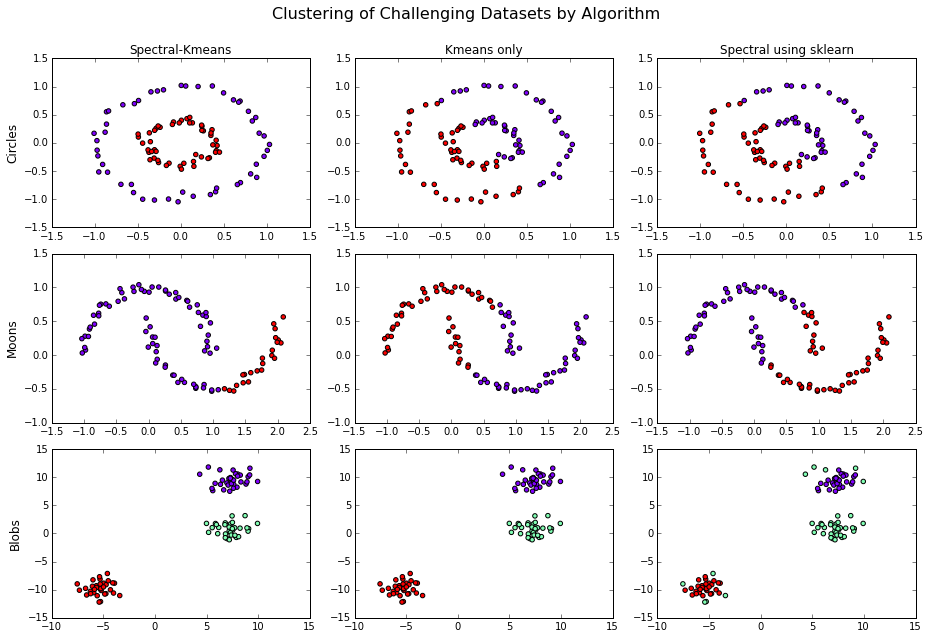

In [46]:
print ('Figure 1')
fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(13,9))


s,y=datasetss[0]
axes[0,0].scatter(s[:,0],s[:,1],c=ownone,cmap=cm.rainbow)
axes[0,0].set_title('Spectral-Kmeans',size=12)
axes[0,0].set_ylabel('Circles',size=12)
axes[0,1].scatter(s[:,0],s[:,1],c=kmeansone,cmap=cm.rainbow)
axes[0,1].set_title('Kmeans only',size=12)
axes[1,0].set_ylabel('Moons',size=12)
axes[0,2].scatter(s[:,0],s[:,1],c=spectralone,cmap=cm.rainbow)
axes[0,2].set_title('Spectral using sklearn',size=12)
axes[2,0].set_ylabel('Blobs',size=12)
s,y=datasetss[1]
axes[1,0].scatter(s[:,0],s[:,1],c=owntwo,cmap=cm.rainbow)
axes[1,1].scatter(s[:,0],s[:,1],c=kmeanstwo,cmap=cm.rainbow)
axes[1,2].scatter(s[:,0],s[:,1],c=spectraltwo,cmap=cm.rainbow)
s,y=datasetss[2]
axes[2,0].scatter(s[:,0],s[:,1],c=ownthree,cmap=cm.rainbow)
axes[2,1].scatter(s[:,0],s[:,1],c=kmeansthree,cmap=cm.rainbow)
axes[2,2].scatter(s[:,0],s[:,1],c=spectralthree,cmap=cm.rainbow)

plt.suptitle('Clustering of Challenging Datasets by Algorithm',size=16)

fig.tight_layout()
fig.subplots_adjust(top=0.90)

In [47]:
print('Table 3: Accuracy in % of each Method by Dataset')
Table3

Table 3: Accuracy in % of each Method by Dataset


,Spectral-Kmeans,Kmeans-only,Spectral using sklearn
Circles,100,50,50
Moons,73,26,77
Blobs,100,100,90


## 6. Discussion and Conclusion

In our report, we recreated the algorithm outlined in (Ng et al, 2002) using Python [1]. We tested our method to ascertain its effectiveness which showed it was in fact. Then we tried to optimize our algorithm using both jit and cython. Jit did not improve the computation time, but using Cython did moderately speed up the process. This was used only on our main algorithm function, and not to the variance-finder function. The reason why the speed up using JIT and Cython is not ideal might be that our functions are heavily based on numpy and scipy but not nested for loops, so numba and Cython can not do much. However, we did try to optimize both our main algorithm and the optimal variance-finder function using multiprocessing parallel computing. This proved to be a worthwhile endeavor as it improved the computation time of our algorithm. The drawbacks of the method were discussed previously, but we essentially lost information by splitting up the datasets. However, in one of our optimization methods, where we split up the array of variances tested, the variance function improved substantially and did not result in a loss of information. This result, in addition to our Cython improvement allows us to recommend using Cython for the main algorithm and our multiprocessing parallelism method to find optimal variance. This is particularly useful if the dataset is large, otherwise it may be more efficient to simply use the Python functions.

We additionally applied the algorithm to a number of challenging clustering problems and compared our algorithm to the spectral clustering method in the module $sklearn$ and applying K-means directly to the data. From the three challenging problems we faced, our algorithm performed better in accumulation than the other two. Recall that the spectral clustering method using in $sklearn$ is very similar to ours, but uses different affinity and Laclanian matrices. This suggests that nuanced differences in calculation of the matrices can result in a large fall in accuracy. Of course, we would need to do a large simulation study to test whether this observation is consistent. 

There are a few limitations in our methodology that have been observed. One is that finding an optimal variance can be very computationally expensive because it essentially means you have to run the algorithm many times, and given a large dataset, it could take a very long time. Using the multiprocessing method can decrease the time, but may still be inefficient. One suggestion would be to draw a random sample of the data that is sufficiently small yet informative and run the multiprocessing method using that sample. This will certainly lose some information, but if the data is randomly selected, the variance should be close to the optimal one, and it would be much more computationally efficient. Another limitation is that we did not do a simulation study and we cannot confirm our accuracy rates, or the efficiency ratios using a large scale. Our report, however, did illustrate that the algorithm works precisely and certain methods have helped improve the computation time. In future research, it would be useful to simulate our results and to verify our accuracy rates and efficiency ratios. Finally, it could be useful to see how our algorithm performs relative to the other methods we tried using larger datasets and more challenging datasets.  

## References

#### 1. Ng, Andrew Y., Michael I. Jordan, and Yair Weiss. "On spectral clustering: Analysis and an algorithm." Advances in neural information processing systems 2 (2002): 849-856.

#### 2. Von Luxburg, Ulrike. "A tutorial on spectral clustering." Statistics and computing 17.4 (2007): 395-416.

#### 3. Merris, Russell. "Laplacian matrices of graphs: a survey." Linear algebra and its applications 197 (1994): 143-176.